In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, average_precision_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [19]:
df = pd.read_csv('../Data/heart_disease_uci.csv')

In [20]:
df = df.dropna()

df = pd.get_dummies(df, drop_first=True)

X_reg = df.drop(columns=['chol'])  
y_reg = df['chol']

X_clf = df.drop(columns=['num'])   
y_clf = (df['num'] > 0).astype(int)

In [21]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_reg_train = scaler.fit_transform(X_reg_train)
X_reg_test = scaler.transform(X_reg_test)

X_clf_train = scaler.fit_transform(X_clf_train)
X_clf_test = scaler.transform(X_clf_test)

In [23]:
alphas = [0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.5, 0.9]

results = []
for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        model.fit(X_reg_train, y_reg_train)
        y_pred = model.predict(X_reg_test)
        r2 = r2_score(y_reg_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
        results.append((alpha, l1_ratio, r2, rmse))

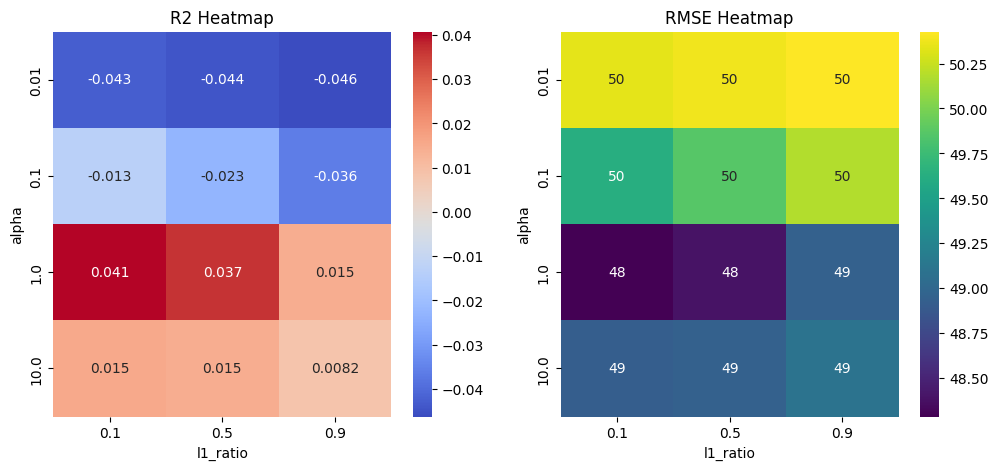

In [24]:
results_df = pd.DataFrame(results, columns=['alpha', 'l1_ratio', 'R2', 'RMSE'])

pivot_r2 = results_df.pivot(index='alpha', columns='l1_ratio', values='R2')
pivot_rmse = results_df.pivot(index='alpha', columns='l1_ratio', values='RMSE')


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(pivot_r2, annot=True, cmap='coolwarm')
plt.title('R2 Heatmap')

plt.subplot(1,2,2)
sns.heatmap(pivot_rmse, annot=True, cmap='viridis')
plt.title('RMSE Heatmap')
plt.show()

In [26]:
neighbors = [1, 5, 10]

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_clf_train, y_clf_train)
    y_pred = model.predict(X_clf_test)
    y_prob = model.predict_proba(X_clf_test)[:,1]
    
    print(f"k={k}")
    print(classification_report(y_clf_test, y_pred))
    print(f"AUROC: {roc_auc_score(y_clf_test, y_prob):.4f}")
    print(f"AUPRC: {average_precision_score(y_clf_test, y_prob):.4f}")

k=1
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        35
           1       0.73      0.88      0.80        25

    accuracy                           0.82        60
   macro avg       0.82      0.83      0.82        60
weighted avg       0.83      0.82      0.82        60

AUROC: 0.8257
AUPRC: 0.6953
k=5
              precision    recall  f1-score   support

           0       0.91      0.86      0.88        35
           1       0.81      0.88      0.85        25

    accuracy                           0.87        60
   macro avg       0.86      0.87      0.86        60
weighted avg       0.87      0.87      0.87        60

AUROC: 0.9366
AUPRC: 0.8935
k=10
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        35
           1       0.85      0.88      0.86        25

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weigh

In [27]:
penalties = ['l2']
solvers = ['lbfgs', 'liblinear']

for penalty in penalties:
    for solver in solvers:
        model = LogisticRegression(penalty=penalty, solver=solver, max_iter=1000)
        model.fit(X_clf_train, y_clf_train)
        y_pred = model.predict(X_clf_test)
        y_prob = model.predict_proba(X_clf_test)[:,1]
        
        print(f"Penalty: {penalty}, Solver: {solver}")
        print(classification_report(y_clf_test, y_pred))
        print(f"AUROC: {roc_auc_score(y_clf_test, y_prob):.4f}")
        print(f"AUPRC: {average_precision_score(y_clf_test, y_prob):.4f}")

Penalty: l2, Solver: lbfgs
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       0.88      0.88      0.88        25

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60

AUROC: 0.9417
AUPRC: 0.9447
Penalty: l2, Solver: liblinear
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       0.88      0.88      0.88        25

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60

AUROC: 0.9417
AUPRC: 0.9447


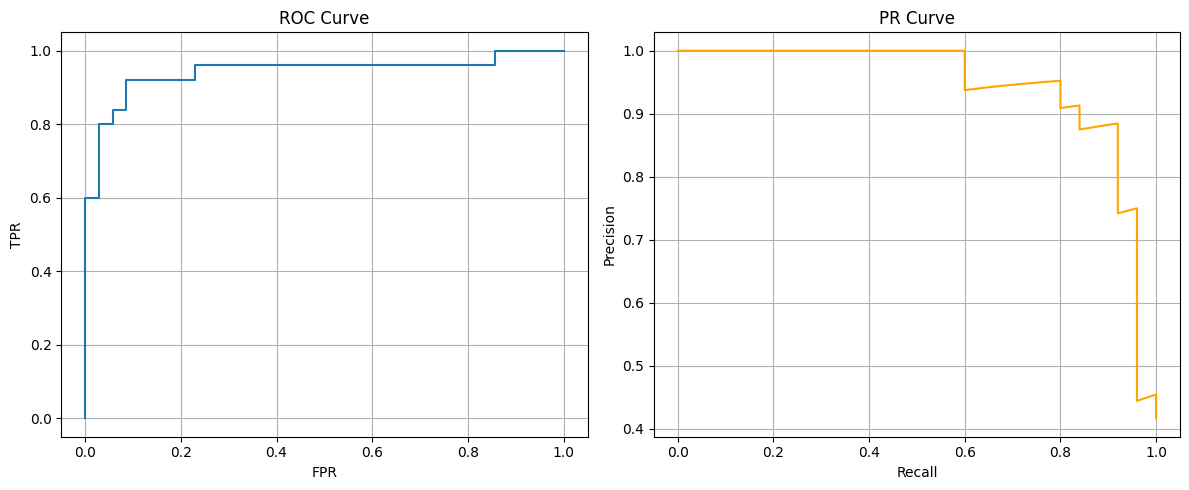

In [28]:
best_model = LogisticRegression(solver='liblinear')
best_model.fit(X_clf_train, y_clf_train)
y_prob = best_model.predict_proba(X_clf_test)[:, 1]

fpr, tpr, _ = roc_curve(y_clf_test, y_prob)
precision, recall, _ = precision_recall_curve(y_clf_test, y_prob)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label='AUROC')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(recall, precision, label='AUPRC', color='orange')
plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

plt.tight_layout()
plt.show()